In [ ]:
!pip install tensorflow==1.15.2
!pip install imgaug
!pip install numpy
!pip install matplotlib
!pip install opencv-python

  Using cached https://files.pythonhosted.org/packages/40/18/74348263763453c9e2b64b057ec4294b7764ee46cfea064340cb8f4ace99/tensorflow-1.15.2-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/de/62/2ee9cd74c9fa2fa450877847ba560b260f5d0fb70ee0595203082dafcc9d/tensorflow_estimator-1.15.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1e/e9/d3d747a97f7188f48aa5eda486907f3b345cd409f0a0850468ba867db246/tensorboard-1.15.0-py3-none-any.whl
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Reshape, Input, Activation, Conv2D, GlobalMaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dense, Lambda, ZeroPadding2D, Dropout, DepthwiseConv2D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import sys
import cv2
import os

# tf.compat.v1.disable_eager_execution()

In [2]:
OBJECT = 'Plate' # Plate / Car / Number
DATASETS = ['GENERATED_DATASET'] # GENERATED, MOROCCAN
BACKEND = 'SqueezeNet' # DarkNet, MobileNet, SqueezeNet

MODEL_SPEC = '{}_{}_{}_Final'.format(OBJECT, BACKEND, '_'.join(DATASETS))

ROOT_DIR = 'C:\\Users\\utilisateur\\Documents\\GitHub\\plate-detector\\'
DATA_DIR = ROOT_DIR + 'data\\'
MODEL_DIR = ROOT_DIR + 'models\\'
LOGS_DIR = ROOT_DIR + 'logs\\'
BACKEND_DIR = ROOT_DIR + 'backends\\'

# l'entrainement des extracteurs prend beaucoup de temps, alors j'ai choisi d'utilisée l'apprentissage transféré,
# c-à-d commencer l'entrainement par les poids des structures déja entrainées sur la classification des images 
# dans le concours ImageNet Object Classification.

SQUEEZENET_BACKEND_PATH = BACKEND_DIR + "squeezenet_backend.h5"
MOBILENET_BACKEND_PATH  = BACKEND_DIR + "mobilenet_backend.h5"

TRAIN_VALID_PROP = 0.8
INPUT_SIZE = 320          # maximum width or height
LABELS = [OBJECT]         # Liste des objets que doit YOLO considérer lors de la détection et entrainement
MAX_BOX_PER_IMAGE = 1     # GENERATED 1, MOROCCAN 26
OBJ_THRESH = 0.5          # Valeur minimale de sûreté/fidélité/confidence pour considérer la détéction positive
NMS_THRESH = 0.5          # Valeur minimale de sûreté/fidélité/confidence pour considérer la détéction positive
ANCHORS = [6.07,2.64, 6.52,4.39, 8.78,3.53, 8.95,5.79, 11.07,7.76, 12.05,4.73, 14.32,9.14, 14.45,6.46, 15.25,11.92]

# GENERATED 320 [1.40,0.55, 2.36,0.96, 3.47,1.42, 4.47,1.93, 5.78,2.40, 6.68,3.27, 7.98,2.70, 8.58,3.70, 9.08,4.67]
# GENERATED 640 [2.74,1.10, 4.39,1.83, 6.31,2.65, 8.47,3.61, 11.02,4.59, 12.80,6.18, 15.97,5.34, 16.70,7.28, 18.21,9.28]

# MOROCCAN 1024 [1.61,0.91, 5.37,2.12, 6.37,5.60, 7.61,2.80, 9.20,4.60, 9.89,3.00, 11.66,3.39, 12.68,4.25, 16.94,6.37]
# MOROCCAN 512 [0.74,0.42, 2.28,0.93, 3.22,2.92, 3.61,1.25, 4.13,1.81, 5.12,2.64, 5.30,1.53, 6.14,1.91, 9.07,3.15]

In [3]:
from Yolo_V2_utils import *
from Yolo_V2_extractors import *
from Yolo_V2_preprocessing import *
from Yolo_V2_detection_head import *

%matplotlib inline

In [4]:
all_imgs, seen_labels = parse_annotation(DATA_DIR, DATASETS)

if INPUT_SIZE < max(all_imgs[0]['width'], all_imgs[0]['height']) :
    print('Check your data input size !!')

train_valid_split = int(TRAIN_VALID_PROP * len(all_imgs))
np.random.shuffle(all_imgs)
valid_imgs = all_imgs[train_valid_split:]
train_imgs = all_imgs[:train_valid_split]
print(seen_labels)

{'Plate': 10000}


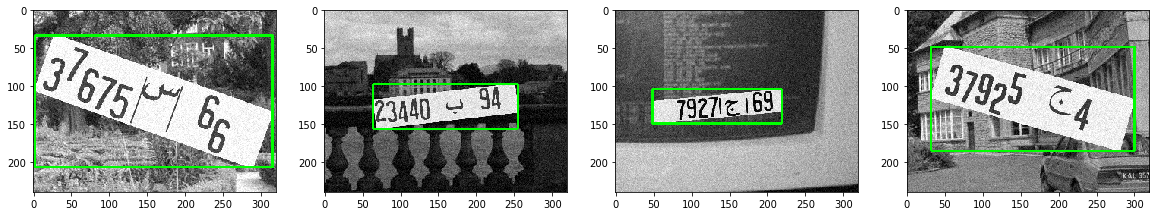

In [5]:
# Visualisation des données

fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    numb = np.random.randint(len(train_imgs))
    rand_img = cv2.imread(train_imgs[numb]['file_name'])
    rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)
    for j in range(len(train_imgs[numb]['object'])) :
        min_labels = (train_imgs[numb]['object'][j]['xmin'], train_imgs[numb]['object'][j]['ymin'])
        max_labels = (train_imgs[numb]['object'][j]['xmax'], train_imgs[numb]['object'][j]['ymax'])
        cv2.rectangle(rand_img, min_labels, max_labels, (0,255,0), 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(rand_img)  
plt.show()

In [6]:
model = YOLO(BACKEND, INPUT_SIZE, LABELS, MAX_BOX_PER_IMAGE, ANCHORS)

Model: "Yolo"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
squeezenet (Model)              (None, 19, 19, 512)  722496      input_1[0][0]                    
__________________________________________________________________________________________________
Couche_de_detection (Conv2D)    (None, 19, 19, 54)   27702       squeezenet[1][0]                 
__________________________________________________________________________________________________
reshape (Reshape)               (None, 19, 19, 9, 6) 0           Couche_de_detection[0][0]        
_______________________________________________________________________________________________

In [7]:
model.train(   train_imgs         = train_imgs, # Les images sur lesquelles le model sera entrainé
               valid_imgs         = valid_imgs, # Les images sur lesquelles la performance du model sera validé
               train_times        = 1, # Le nombre de fois pour répéter l'entrainement
               valid_times        = 1, # Le nombre de fois pourrépéter la validation
               nb_epochs          = 100, # Le nombre d'époques
               learning_rate      = 1e-4, # Le taux d'apprentissage initial : \ethat_{0}
               batch_size         = 16, # La taille du batch : Puisqu'on utilise un entrainement par batch
               warmup_epochs      = 3, # Des époques pour l'échauffement permet la familiarisation avec les données
               object_scale       = 5, # Pénalité sur les fausse négative : un objet n'est pas détecté
               no_object_scale    = 1, # Pénalité sur les fausse positive : une détection d'objets inexistant
               coord_scale        = 1, # Pénalité sur les coordonnées du centre de l'objet
               class_scale        = 1, # Pénalité sur les dimensions de l'objet détecté
               saved_weights_dir  = MODEL_DIR,
               logs_dir           = f"{LOGS_DIR}{BACKEND}_{DATASETS[0]}" ,
               debug              = True)

ValueError: Tried to convert 'x' to a tensor and failed. Error: None values not supported.